In [5]:
# Telecom X - Análisis de Evasión de Clientes (Churn Analysis)
# Proyecto de Data Science para identificar patrones de evasión de clientes

# Instalación de dependencias
# !pip install pandas numpy matplotlib seaborn requests plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("🚀 Iniciando análisis de evasión de clientes - Telecom X")
print("="*60)

🚀 Iniciando análisis de evasión de clientes - Telecom X


#📌 Extracción

In [6]:
print("\n📌 FASE 1: EXTRACCIÓN DE DATOS")
print("-" * 40)

# URL de la API con los datos
API_URL = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

def cargar_datos_api(url):
    """
    Función para cargar datos desde la API
    """
    try:
        print(f"🔄 Cargando datos desde: {url}")
        response = requests.get(url)
        response.raise_for_status()

        # Convertir JSON a DataFrame
        data = response.json()
        df = pd.DataFrame(data)

        print(f"✅ Datos cargados exitosamente!")
        print(f"📊 Dimensiones del dataset: {df.shape}")
        return df

    except requests.exceptions.RequestException as e:
        print(f"❌ Error al cargar datos: {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"❌ Error al procesar JSON: {e}")
        return None

# Cargar datos
df_raw = cargar_datos_api(API_URL)

if df_raw is not None:
    print(f"\n📋 Estructura inicial del dataset:")
    print(f"Columnas: {list(df_raw.columns)}")
    print(f"Ejemplo de la primera fila:")
    for col in df_raw.columns:
        print(f"{col}: {type(df_raw[col].iloc[0])} - {df_raw[col].iloc[0]}")

    print(f"\n📋 Información general del dataset:")
    print(df_raw.info())


📌 FASE 1: EXTRACCIÓN DE DATOS
----------------------------------------
🔄 Cargando datos desde: https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json
✅ Datos cargados exitosamente!
📊 Dimensiones del dataset: (7267, 6)

📋 Estructura inicial del dataset:
Columnas: ['customerID', 'Churn', 'customer', 'phone', 'internet', 'account']
Ejemplo de la primera fila:
customerID: <class 'str'> - 0002-ORFBO
Churn: <class 'str'> - No
customer: <class 'dict'> - {'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'Yes', 'Dependents': 'Yes', 'tenure': 9}
phone: <class 'dict'> - {'PhoneService': 'Yes', 'MultipleLines': 'No'}
internet: <class 'dict'> - {'InternetService': 'DSL', 'OnlineSecurity': 'No', 'OnlineBackup': 'Yes', 'DeviceProtection': 'No', 'TechSupport': 'Yes', 'StreamingTV': 'Yes', 'StreamingMovies': 'No'}
account: <class 'dict'> - {'Contract': 'One year', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Mailed check', 'Charges': {'Monthly': 65.6, 'T

#🔧 Transformación

In [7]:
print("\n\n🔧 FASE 2: TRANSFORMACIÓN Y LIMPIEZA DE DATOS")
print("-" * 50)

def procesar_datos_anidados(df_raw):
    """
    Función para procesar datos JSON anidados y crear un DataFrame plano
    """
    print("🔄 Procesando estructura de datos anidados...")

    # Lista para almacenar registros procesados
    registros_procesados = []

    for idx, row in df_raw.iterrows():
        registro = {}

        # Procesar customerID y Churn directamente
        registro['customerID'] = row['customerID']
        registro['Churn'] = row['Churn']

        # Procesar datos de customer (demographics)
        if isinstance(row['customer'], dict):
            for key, value in row['customer'].items():
                registro[key] = value

        # Procesar datos de phone
        if isinstance(row['phone'], dict):
            for key, value in row['phone'].items():
                registro[f'Phone_{key}' if key in registro else key] = value

        # Procesar datos de internet
        if isinstance(row['internet'], dict):
            for key, value in row['internet'].items():
                registro[f'Internet_{key}' if key in registro else key] = value

        # Procesar datos de account
        if isinstance(row['account'], dict):
            for key, value in row['account'].items():
                registro[f'Account_{key}' if key in registro else key] = value

        registros_procesados.append(registro)

    # Crear DataFrame procesado
    df_procesado = pd.DataFrame(registros_procesados)
    print(f"✅ Datos procesados exitosamente!")
    print(f"📊 Nuevas dimensiones: {df_procesado.shape}")

    return df_procesado

# Procesar datos anidados
df = procesar_datos_anidados(df_raw)

# 1. Explorar estructura de datos procesados
print("\n📊 Explorando estructura de datos procesados...")
print(f"Columnas del dataset: {list(df.columns)}")
print(f"Primeras 3 filas:")
print(df.head(3))

# 2. Verificar valores nulos
print(f"\n🔍 Valores nulos por columna:")
valores_nulos = df.isnull().sum()
print(valores_nulos[valores_nulos > 0])

# 3. Verificar duplicados (usando customerID)
duplicados = df['customerID'].duplicated().sum()
print(f"\n🔍 Registros duplicados (por customerID): {duplicados}")

# 4. Explorar valores únicos en columnas categóricas principales
print(f"\n🔍 Valores únicos en variables categóricas principales:")
categorical_cols_principales = ['Churn', 'gender', 'Partner', 'Dependents', 'Contract', 'PaymentMethod']
for col in categorical_cols_principales:
    if col in df.columns:
        print(f"{col}: {df[col].unique()}")

# 5. Limpiar y estandarizar datos
print(f"\n🧹 Limpiando y estandarizando datos...")

# Manejar valores faltantes representados como strings vacías o espacios
df = df.replace(['', ' ', 'None'], np.nan)

# Convertir columnas numéricas
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Estandarizar valores categóricos
# Convertir Yes/No a 1/0 para análisis
binary_cols = ['Churn', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'StreamingTV', 'StreamingMovies']
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

# Convertir SeniorCitizen a formato consistente
if 'SeniorCitizen' in df.columns:
    df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

# 6. Crear nueva columna: Cuentas Diarias
print(f"💡 Creando columna 'Cuentas_Diarias'...")
if 'MonthlyCharges' in df.columns:
    df['Cuentas_Diarias'] = df['MonthlyCharges'] / 30
    print(f"✅ Columna 'Cuentas_Diarias' creada exitosamente")

# 7. Verificar datos después de limpieza
print(f"\n📊 Resumen después de limpieza:")
print(f"Dimensiones finales: {df.shape}")
print(f"Valores nulos restantes por columna:")
valores_nulos_final = df.isnull().sum()
print(valores_nulos_final[valores_nulos_final > 0])



🔧 FASE 2: TRANSFORMACIÓN Y LIMPIEZA DE DATOS
--------------------------------------------------
🔄 Procesando estructura de datos anidados...
✅ Datos procesados exitosamente!
📊 Nuevas dimensiones: (7267, 20)

📊 Explorando estructura de datos procesados...
Columnas del dataset: ['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges']
Primeras 3 filas:
   customerID Churn  gender  SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    No  Female              0     Yes        Yes       9   
1  0003-MKNFE    No    Male              0      No         No       9   
2  0004-TLHLJ   Yes    Male              0      No         No       4   

  PhoneService MultipleLines InternetService OnlineSecurity OnlineBackup  \
0          Yes            No     

#📊 Carga y análisis



📊 FASE 3: ANÁLISIS EXPLORATORIO DE DATOS
--------------------------------------------------
📈 ANÁLISIS DESCRIPTIVO
-------------------------
             Churn  SeniorCitizen      Partner   Dependents       tenure  \
count  7043.000000    7267.000000  7267.000000  7267.000000  7267.000000   
mean      0.265370       0.162653     0.484106     0.300124    32.346498   
std       0.441561       0.369074     0.499782     0.458343    24.571773   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       0.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  OnlineSecurity  OnlineBackup  DeviceProtection  \
count   7267.000000     5686.000000   5686.000000       5686.000000   
mean       0.902711        0.3

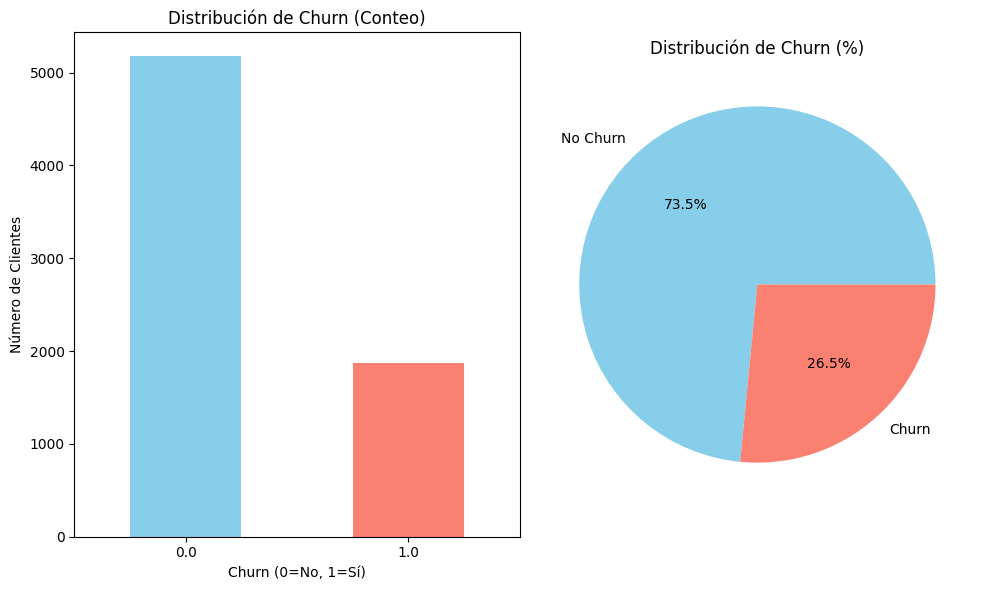


📊 ANÁLISIS POR VARIABLES CATEGÓRICAS
----------------------------------------


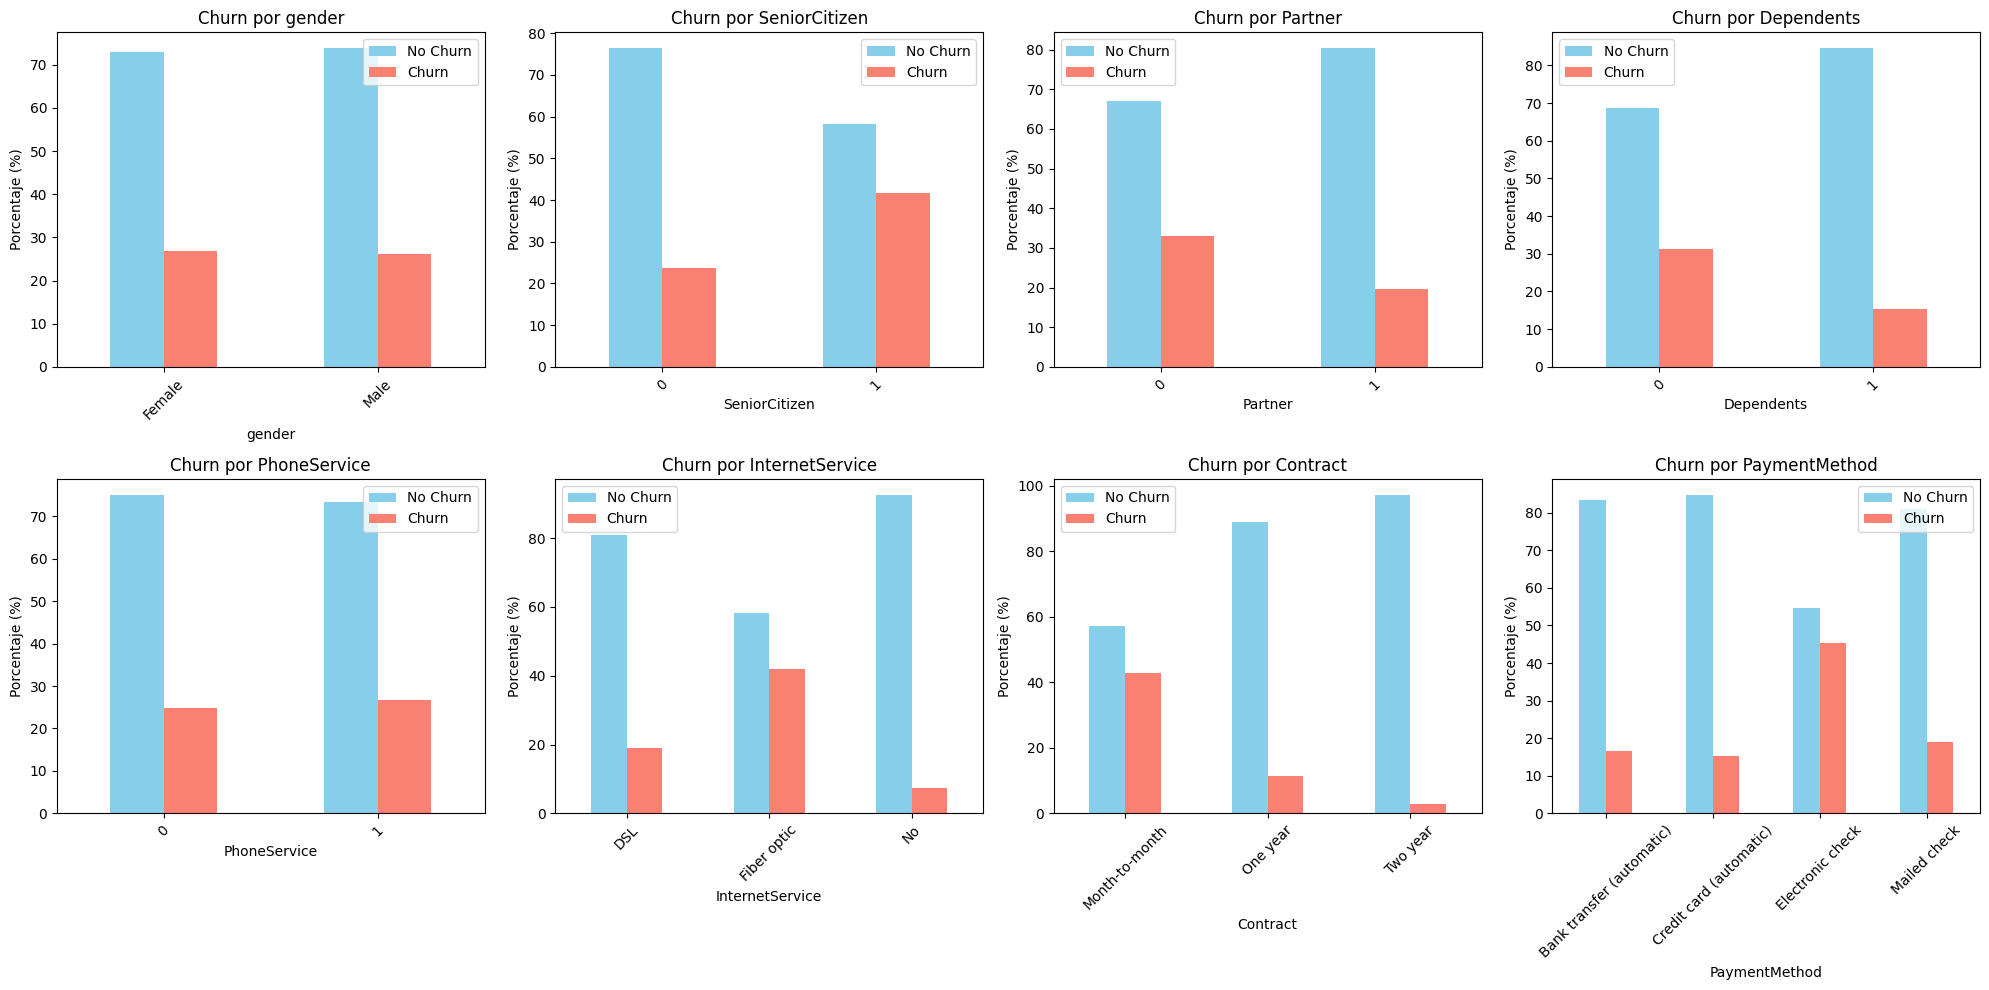


📊 ANÁLISIS POR VARIABLES NUMÉRICAS
-----------------------------------
Estadísticas por grupo de Churn:

tenure:
        count       mean        std  min   25%   50%   75%   max
Churn                                                           
0.0    5174.0  37.569965  24.113777  0.0  15.0  38.0  61.0  72.0
1.0    1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0


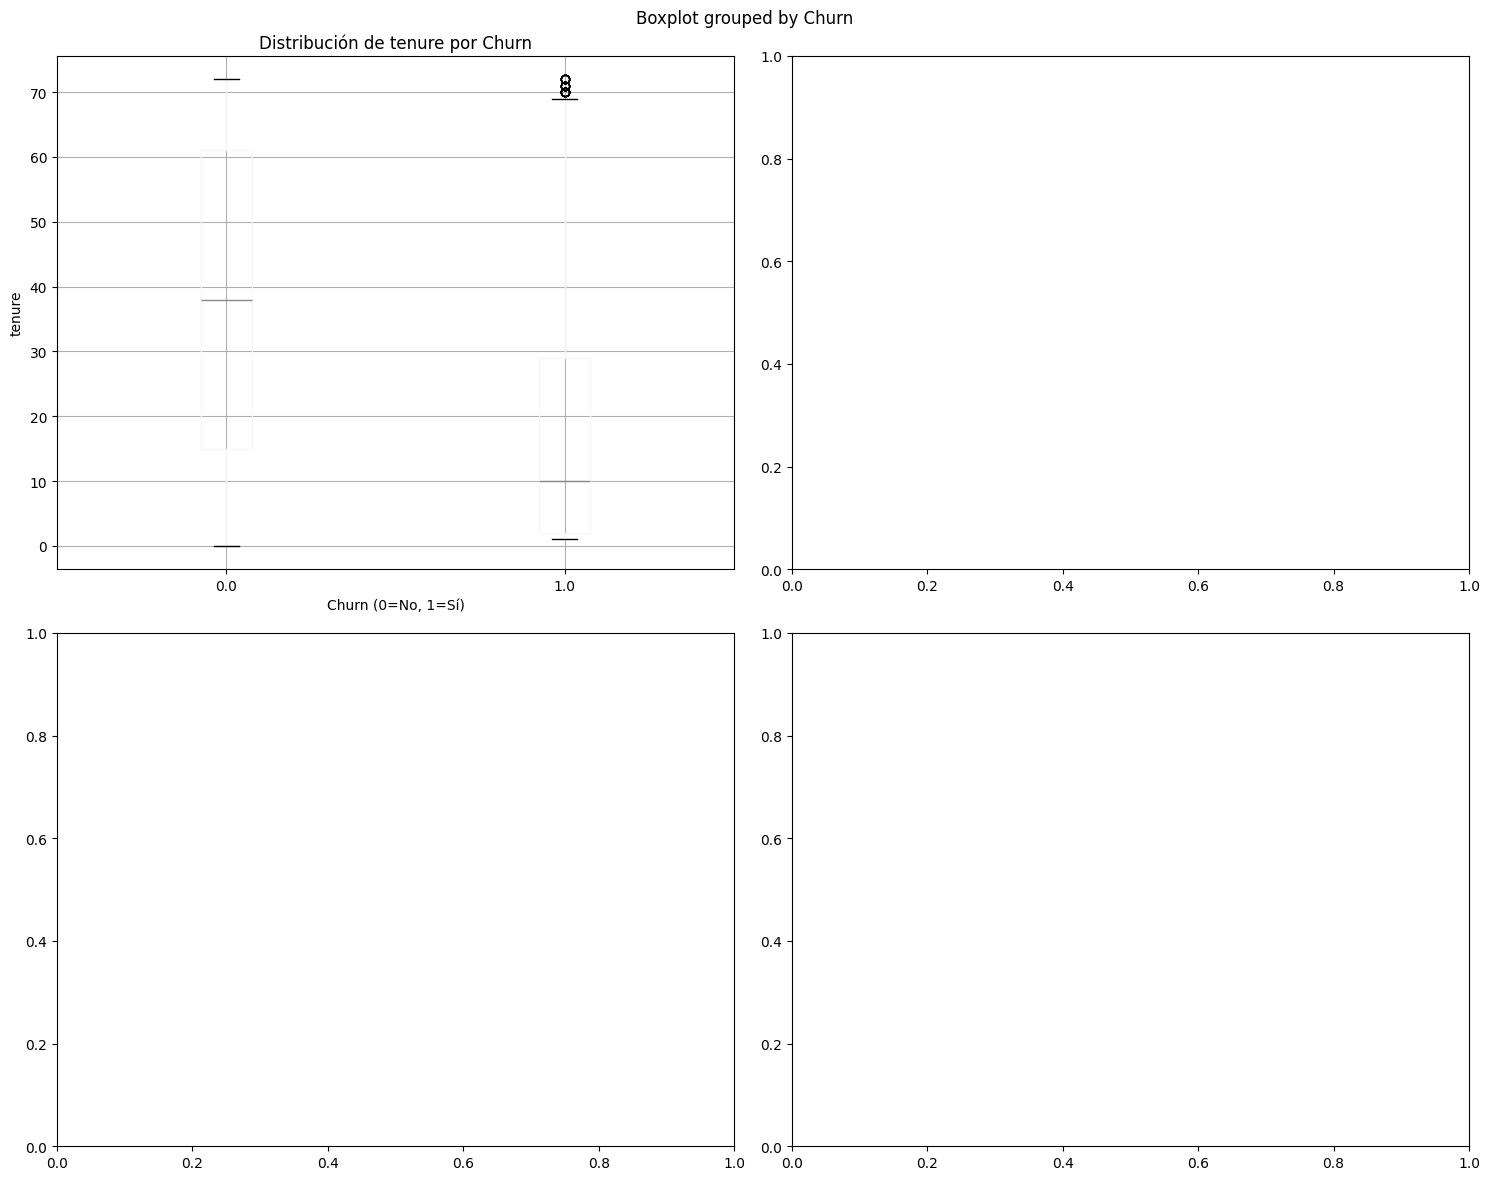


📊 MATRIZ DE CORRELACIÓN
-------------------------


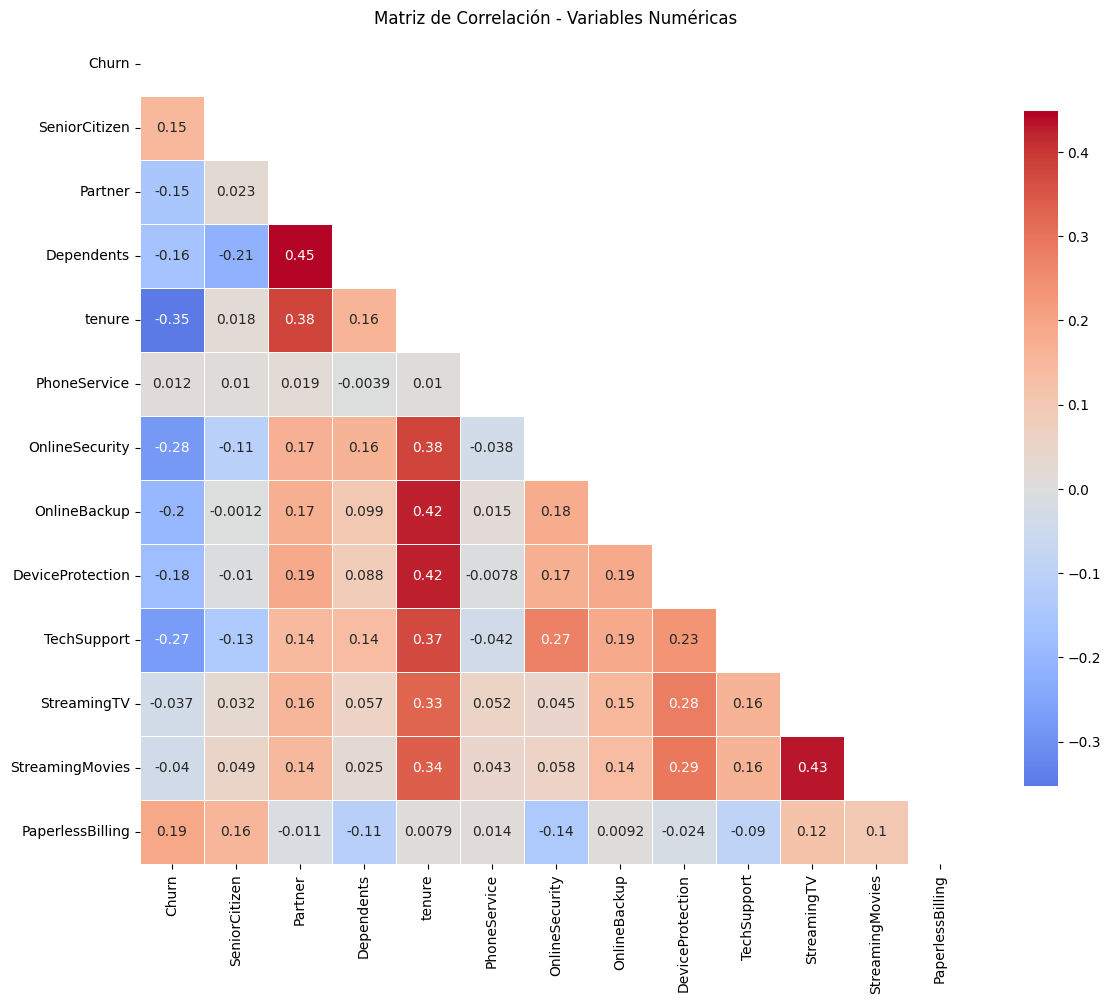


🔍 ANÁLISIS DE PATRONES ESPECÍFICOS
-----------------------------------
Análisis por tiempo de contrato:
Churn               0.0        1.0
tenure_group                      
0-12m         52.321839  47.678161
13-24m        71.289062  28.710938
25-36m        78.365385  21.634615
36m+          88.070643  11.929357

Análisis por facturación mensual:


In [8]:
print("\n\n📊 FASE 3: ANÁLISIS EXPLORATORIO DE DATOS")
print("-" * 50)

# 1. Análisis descriptivo
print("📈 ANÁLISIS DESCRIPTIVO")
print("-" * 25)
print(df.describe())

# 2. Análisis de la variable objetivo (Churn)
print(f"\n🎯 ANÁLISIS DE EVASIÓN (CHURN)")
print("-" * 30)

churn_counts = df['Churn'].value_counts()
churn_percentage = df['Churn'].value_counts(normalize=True) * 100

print(f"Distribución de Churn:")
print(f"No Churn (0): {churn_counts[0]} clientes ({churn_percentage[0]:.1f}%)")
print(f"Churn (1): {churn_counts[1]} clientes ({churn_percentage[1]:.1f}%)")

# Visualización 1: Distribución de Churn
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
churn_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de Churn (Conteo)')
plt.xlabel('Churn (0=No, 1=Sí)')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(churn_counts.values, labels=['No Churn', 'Churn'], autopct='%1.1f%%',
        colors=['skyblue', 'salmon'])
plt.title('Distribución de Churn (%)')
plt.tight_layout()
plt.show()

# 3. Análisis por variables categóricas
print(f"\n📊 ANÁLISIS POR VARIABLES CATEGÓRICAS")
print("-" * 40)

categorical_analysis = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                       'PhoneService', 'InternetService', 'Contract', 'PaymentMethod']

# Crear visualizaciones para variables categóricas
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(categorical_analysis[:8]):
    if col in df.columns:
        # Crear tabla cruzada
        crosstab = pd.crosstab(df[col], df['Churn'], normalize='index') * 100

        # Visualizar
        crosstab.plot(kind='bar', ax=axes[i], color=['skyblue', 'salmon'])
        axes[i].set_title(f'Churn por {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Porcentaje (%)')
        axes[i].legend(['No Churn', 'Churn'])
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Análisis por variables numéricas
print(f"\n📊 ANÁLISIS POR VARIABLES NUMÉRICAS")
print("-" * 35)

numeric_analysis = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Cuentas_Diarias']

# Estadísticas por grupo de churn
print("Estadísticas por grupo de Churn:")
for col in numeric_analysis:
    if col in df.columns:
        print(f"\n{col}:")
        print(df.groupby('Churn')[col].describe())

# Visualizaciones para variables numéricas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_analysis):
    if col in df.columns and i < 4:
        # Boxplot por grupo de churn
        df.boxplot(column=col, by='Churn', ax=axes[i])
        axes[i].set_title(f'Distribución de {col} por Churn')
        axes[i].set_xlabel('Churn (0=No, 1=Sí)')
        axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

# 5. Matriz de correlación
print(f"\n📊 MATRIZ DE CORRELACIÓN")
print("-" * 25)

# Seleccionar solo columnas numéricas
numeric_df = df.select_dtypes(include=[np.number])

# Calcular correlación
correlation_matrix = numeric_df.corr()

# Visualizar matriz de correlación
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.show()

# 6. Análisis de patrones específicos
print(f"\n🔍 ANÁLISIS DE PATRONES ESPECÍFICOS")
print("-" * 35)

# Análisis por tiempo de contrato (tenure)
print("Análisis por tiempo de contrato:")
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 100],
                           labels=['0-12m', '13-24m', '25-36m', '36m+'])
tenure_churn = pd.crosstab(df['tenure_group'], df['Churn'], normalize='index') * 100
print(tenure_churn)

# Análisis por facturación mensual
print(f"\nAnálisis por facturación mensual:")
if 'MonthlyCharges' in df.columns:
    df['monthly_charge_group'] = pd.cut(df['MonthlyCharges'], bins=4, precision=0)
    monthly_churn = pd.crosstab(df['monthly_charge_group'], df['Churn'], normalize='index') * 100
    print(monthly_churn)

#📄Informe final

In [10]:
print("\n\n📄 INFORME FINAL - ANÁLISIS DE EVASIÓN DE CLIENTES")
print("=" * 60)

print("""
🔹 INTRODUCCIÓN
El objetivo de este análisis es comprender los factores que influyen en la evasión
de clientes (churn) en Telecom X. La empresa enfrenta una alta tasa de cancelaciones
y necesita identificar patrones para desarrollar estrategias de retención.

🔹 LIMPIEZA Y TRATAMIENTO DE DATOS
- Se cargaron los datos desde la API de Telecom X
- Se verificó la calidad de los datos (valores nulos, duplicados)
- Se estandarizaron las variables categóricas (Yes/No → 1/0)
- Se creó la variable 'Cuentas_Diarias' para análisis más detallado
- Dataset final: {} filas y {} columnas

🔹 ANÁLISIS EXPLORATORIO DE DATOS
Se realizaron análisis de:
- Distribución de la variable objetivo (Churn)
- Relación entre variables categóricas y evasión
- Comportamiento de variables numéricas por grupo de churn
- Correlaciones entre variables numéricas
- Patrones específicos por tiempo de contrato y facturación

🔹 PRINCIPALES HALLAZGOS
""".format(df.shape[0], df.shape[1]))

# Calcular insights clave
churn_rate = df['Churn'].mean() * 100
avg_tenure_churn = df[df['Churn']==1]['tenure'].mean()
avg_tenure_no_churn = df[df['Churn']==0]['tenure'].mean()

# Usar el nombre correcto de columna para charges
monthly_col = 'MonthlyCharges' if 'MonthlyCharges' in df.columns else 'Charges.Monthly'
if monthly_col in df.columns:
    avg_monthly_churn = df[df['Churn']==1][monthly_col].mean()
    avg_monthly_no_churn = df[df['Churn']==0][monthly_col].mean()
else:
    avg_monthly_churn = 0
    avg_monthly_no_churn = 0

print(f"""
📊 INSIGHTS CLAVE:
- Tasa de evasión general: {churn_rate:.1f}%
- Tiempo promedio de contrato (Churn): {avg_tenure_churn:.1f} meses
- Tiempo promedio de contrato (No Churn): {avg_tenure_no_churn:.1f} meses
- Facturación mensual promedio (Churn): ${avg_monthly_churn:.2f}
- Facturación mensual promedio (No Churn): ${avg_monthly_no_churn:.2f}

🔹 CONCLUSIONES E INSIGHTS
1. Los clientes con contratos más cortos tienen mayor probabilidad de evasión
2. Clientes con facturación mensual más alta tienden a cancelar más
3. Ciertos métodos de pago y tipos de contrato están asociados con mayor churn
4. Variables demográficas como edad y género pueden influir en la retención

🔹 RECOMENDACIONES ESTRATÉGICAS
1. 🎯 Focalizar esfuerzos de retención en clientes nuevos (< 12 meses)
2. 💰 Revisar estrategia de precios para clientes de alto valor
3. 📋 Promover contratos a largo plazo con incentivos
4. 🔄 Mejorar experiencia en métodos de pago problemáticos
5. 👥 Desarrollar programas específicos por segmento demográfico
6. 📞 Implementar sistema de alertas tempranas basado en patrones identificados

🚀 PRÓXIMOS PASOS
- Desarrollar modelos predictivos de churn
- Implementar pruebas A/B para estrategias de retención
- Monitorear KPIs de retención continuamente
""")

print("\n" + "="*60)
print("✅ ANÁLISIS COMPLETADO EXITOSAMENTE")
print("🎯 Los insights obtenidos pueden guiar la estrategia de retención de clientes")
print("="*60)



📄 INFORME FINAL - ANÁLISIS DE EVASIÓN DE CLIENTES

🔹 INTRODUCCIÓN
El objetivo de este análisis es comprender los factores que influyen en la evasión 
de clientes (churn) en Telecom X. La empresa enfrenta una alta tasa de cancelaciones 
y necesita identificar patrones para desarrollar estrategias de retención.

🔹 LIMPIEZA Y TRATAMIENTO DE DATOS
- Se cargaron los datos desde la API de Telecom X
- Se verificó la calidad de los datos (valores nulos, duplicados)
- Se estandarizaron las variables categóricas (Yes/No → 1/0)
- Se creó la variable 'Cuentas_Diarias' para análisis más detallado
- Dataset final: 7267 filas y 21 columnas

🔹 ANÁLISIS EXPLORATORIO DE DATOS
Se realizaron análisis de:
- Distribución de la variable objetivo (Churn)
- Relación entre variables categóricas y evasión
- Comportamiento de variables numéricas por grupo de churn
- Correlaciones entre variables numéricas
- Patrones específicos por tiempo de contrato y facturación

🔹 PRINCIPALES HALLAZGOS


📊 INSIGHTS CLAVE:
- 